<a href="https://colab.research.google.com/github/coleb9/Time-Series-Project/blob/tcn_model/Time_Series_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project — Electricity Load & Renewable Forecasting

This notebook contains the full workflow for our time series forecasting project:

- Loading and preparing the OPSD dataset
- Feature engineering
- Creating sliding windows
- Building LSTM, GRU, and Transformer models
- Training and evaluating models
- Comparing performance


# Pre-Processing

In [2]:
from google.colab import files
uploaded = files.upload()

Saving time_series_60min_singleindex.csv to time_series_60min_singleindex (2).csv


In [3]:
import pandas as pd

df = pd.read_csv("time_series_60min_singleindex.csv")

# Select only the German columns we need
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",
    "DE_wind_onshore_generation_actual",
    "DE_solar_generation_actual"
]

df = df[columns]
df.head()


,utc_timestamp,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
0,2014-12-31T23:00:00Z,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,41151.0,8336.0,NaN
2,2015-01-01T01:00:00Z,40135.0,8540.0,NaN
3,2015-01-01T02:00:00Z,39106.0,8552.0,NaN
4,2015-01-01T03:00:00Z,38765.0,8643.0,NaN


In [4]:
# Convert timestamp to proper datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set it as the index
df = df.set_index('utc_timestamp')

# Sort by time just to be safe
df = df.sort_index()

df.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,8336.0,NaN
2015-01-01 01:00:00+00:00,40135.0,8540.0,NaN
2015-01-01 02:00:00+00:00,39106.0,8552.0,NaN
2015-01-01 03:00:00+00:00,38765.0,8643.0,NaN


In [5]:
# Check how many missing values exist
df.isna().sum()

# Ensure all numeric columns are actually numeric (required for interpolation)
df = df.apply(pd.to_numeric, errors='coerce')

# Interpolate missing values based on time
df = df.interpolate(method='time')

# Fill any NaNs that remain at the very start or end (edges)
df = df.ffill().bfill()

# Confirm everything is filled now
df.isna().sum()


,0
DE_load_actual_entsoe_transparency,0
DE_wind_onshore_generation_actual,0
DE_solar_generation_actual,0


In [6]:
# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek    # Monday=0, Sunday=6
df['month'] = df.index.month

df.head()

,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,41151.0,8336.0,71.0,23,2,12
2015-01-01 00:00:00+00:00,41151.0,8336.0,71.0,0,3,1
2015-01-01 01:00:00+00:00,40135.0,8540.0,71.0,1,3,1
2015-01-01 02:00:00+00:00,39106.0,8552.0,71.0,2,3,1
2015-01-01 03:00:00+00:00,38765.0,8643.0,71.0,3,3,1


In [7]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler for all columns
scaler = MinMaxScaler()

# Fit and transform the DataFrame
scaled_values = scaler.fit_transform(df)

# Convert back to a DataFrame with the same index and column names
df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=df.columns)

df_scaled.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,0.212880,0.202225,0.002155,1.000000,0.333333,1.0
2015-01-01 00:00:00+00:00,0.212880,0.202225,0.002155,0.000000,0.500000,0.0
2015-01-01 01:00:00+00:00,0.190909,0.207245,0.002155,0.043478,0.500000,0.0
2015-01-01 02:00:00+00:00,0.168656,0.207541,0.002155,0.086957,0.500000,0.0
2015-01-01 03:00:00+00:00,0.161282,0.209780,0.002155,0.130435,0.500000,0.0


In [8]:
import numpy as np

# We will predict this column:
target_col = "DE_load_actual_entsoe_transparency"

# How many past hours to use
window_size = 24

data = df_scaled.copy()

X_list = []
y_list = []

target_idx = data.columns.get_loc(target_col)

for i in range(len(data) - window_size):
    # past 24 hours of all features
    X_list.append(data.iloc[i : i + window_size].values)
    # load value at the next hour
    y_list.append(data.iloc[i + window_size, target_idx])

X = np.array(X_list)
y = np.array(y_list)

X.shape, y.shape


((50377, 24, 6), (50377,))

In [9]:
# Sizes
n = len(X)

train_size = int(n * 0.70)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

# Split chronologically
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]

X_test = X[train_size + val_size :]
y_test = y[train_size + val_size :]

X_train.shape, X_val.shape, X_test.shape


((35263, 24, 6), (7556, 24, 6), (7558, 24, 6))

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Check shapes just to be sure (uses your existing variables)
print(f"Input Shape: {X_train.shape}")

Input Shape: (35263, 24, 6)


In [26]:
def tcn_residual_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    """
    Creates one TCN residual block:
    Input -> [Dilated Conv -> ReLU -> Dropout] x2 -> Add to Input
    """
    # 1. Save input for the residual connection
    shortcut = x

    # 2. First Dilated Convolution
    x = layers.Conv1D(filters=filters,
                      kernel_size=kernel_size,
                      dilation_rate=dilation_rate,
                      padding='causal',
                      activation='relu')(x)
    x = layers.SpatialDropout1D(rate=dropout_rate)(x)

    # 3. Second Dilated Convolution
    x = layers.Conv1D(filters=filters,
                      kernel_size=kernel_size,
                      dilation_rate=dilation_rate,
                      padding='causal',
                      activation='relu')(x)
    x = layers.SpatialDropout1D(rate=dropout_rate)(x)

    # 4. Dimension Matching
    # If we changed filters (e.g., 32 -> 64), we project the shortcut to match
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv1D(filters=filters, kernel_size=1, padding='same')(shortcut)

    # 5. Add Residual (Input + Output)
    res = layers.Add()([shortcut, x])
    return res

In [33]:
def build_tcn(input_shape, num_layers, filters, kernel_size, dropout):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    # Stack TCN Blocks
    for i in range(num_layers):
        dilation = 2 ** i
        x = tcn_residual_block(x, filters, kernel_size, dilation, dropout)

    # Slicing: Take only the last time step for forecasting
    x = layers.Lambda(lambda k: k[:, -1, :], name="Lambda")(x)

    # Output Layer combines features into 1 single number, the predicted load
    outputs = layers.Dense(1, name="Dense")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="TCN_Model")
    return model

model = build_tcn(
    input_shape=X_train.shape[1:],
    num_layers=4,
    filters=64,
    kernel_size=3,
    dropout=0.2
)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# --- VISUALIZE DESIGN ---
# This shows you the exact shape at every layer
model.summary()

Model: "TCN_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 24, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 24, 64)    │      1,216 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 24, 64)    │          0 │ conv1d_36[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 24, 64)    │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 24, 64)    │        448 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 24, 64)    │          0 │ conv1d_37[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 24, 64)    │          0 │ conv1d_38[0][0],  │
│                     │                   │            │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 24, 64)    │     12,352 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 24, 64)    │          0 │ conv1d_39[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 24, 64)    │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 24, 64)    │          0 │ conv1d_40[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 24, 64)    │          0 │ add_16[0][0],     │
│                     │                   │            │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 24, 64)    │     12,352 │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 24, 64)    │          0 │ conv1d_41[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 24, 64)    │     12,352 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 24, 64)    │          0 │ conv1d_42[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 24, 64)    │          0 │ add_17[0][0],     │
│                     │                   │            │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 24, 64)    │     12,352 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_… │ (None, 24, 64)    │          0 │ conv1d_43[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 88,193 (344.50 KB)

 Trainable params: 88,193 (344.50 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

In [35]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=128,
    callbacks=[early_stop, reduce_lr],
    verbose=1  # Shows progress bar for every epoch
)

Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - loss: 0.0388 - mae: 0.1262 - val_loss: 0.0021 - val_mae: 0.0376 - learning_rate: 0.0010
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 81ms/step - loss: 0.0020 - mae: 0.0345 - val_loss: 7.4854e-04 - val_mae: 0.0208 - learning_rate: 0.0010
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - loss: 0.0011 - mae: 0.0257 - val_loss: 6.5532e-04 - val_mae: 0.0195 - learning_rate: 0.0010
Epoch 4/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - loss: 8.0208e-04 - mae: 0.0215 - val_loss: 3.9506e-04 - val_mae: 0.0148 - learning_rate: 0.0010
Epoch 5/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - loss: 6.6169e-04 - mae: 0.0196 - val_loss: 3.3359e-04 - val_mae: 0.0136 - learning_rate: 0.0010
Epoch 6/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - loss: 5.6088e-04 - mae: 0.0180 - val_loss: 3.3897e-04 - val_mae: 0.0138 - learning_rate: 0.0010
Epoch 7/50
275/276 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 5.0831e-04 - mae: 0.0171
Epoch 7: ReduceLRO

Generating predictions...

--- Real World Accuracy ---
MAE:  496.38 MW
RMSE: 643.93 MW


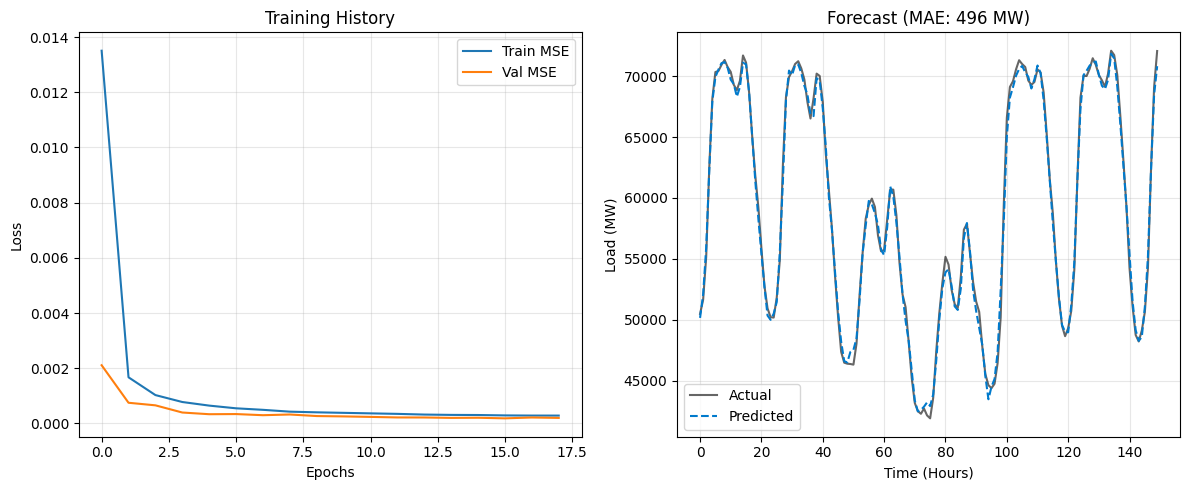

In [38]:
# 1. Plot Learning Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Unscale Predictions (Back to MW)
print("Generating predictions...")
preds_scaled = model.predict(X_test, verbose=0).flatten()
y_test_scaled = y_test.flatten()

# Use scaler constants to reverse the math
# target_idx should be defined in your preprocessing steps (usually 0 or 1)
col_scale = scaler.scale_[target_idx]
col_min = scaler.min_[target_idx]

preds_real = (preds_scaled - col_min) / col_scale
actual_real = (y_test_scaled - col_min) / col_scale

# 3. Calculate Real Metrics
mae_real = np.mean(np.abs(preds_real - actual_real))
mse_real = np.mean((preds_real - actual_real)**2)
rmse_real = np.sqrt(mse_real)

print(f"\n--- Real World Accuracy ---")
print(f"MAE:  {mae_real:.2f} MW")
print(f"RMSE: {rmse_real:.2f} MW")

# 4. Forecast Plot
plt.subplot(1, 2, 2)
# Plot first 150 hours
plt.plot(actual_real[:150], label='Actual', color='black', alpha=0.6)
plt.plot(preds_real[:150], label='Predicted', color='#007acc', linestyle='--')
plt.title(f'Forecast (MAE: {mae_real:.0f} MW)')
plt.ylabel('Load (MW)')
plt.xlabel('Time (Hours)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()